In [1]:
from csv import writer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error

In [8]:
def plot_train_progress_1(loss_train, loss_test, iters_per_point, total_iters=None):

    fig, axes = plt.subplots(1, 1, sharex=False, sharey=False)
    x_points = range(0, len(loss_train)*iters_per_point, iters_per_point)
    
    axes.plot(x_points, loss_train, color="red", label="Training loss", linewidth=1)
    axes.plot(x_points, loss_test, color="blue", label="Test loss", linewidth=1)
    axes.set_title("Training loss", fontsize=10, y=1.022)
    axes.yaxis.grid(True, zorder=0)
    axes.set_xlabel('Iteration', fontsize=10)
    if total_iters is not None:
        axes.set_xlim([0,total_iters])
    axes.set_ylim([0,None])
    axes.legend(loc='upper right')
    plt.show()

def get_random_batch(train_features, train_y, batch_size, rng):

    indices = range(0, batch_size)
    indices = rng.randint(low=0, high=train_features.shape[0], size=batch_size, dtype='int32')
    
    train_features_batch = train_features[indices]
    if train_y is not None:
        train_y_batch = train_y[indices]
    else:
        train_y_batch = None
    return [train_features_batch, train_y_batch]

def training_network(net,
                    loss_func,
                    rng,
                    train_inputs_all,
                    train_y_all,
                    test_values_all,
                    test_y_all,
                    batch_size,
                    learning_rate,
                    total_iters,
                    iters_per_recon_plot=-1):

    values_to_plot = {'loss_train':[], 'loss_test': []}
    
    optimizer = torch.optim.Adam(net.params, lr=learning_rate)
        
    for t in range(total_iters):
        x_imgs, x_targets = get_random_batch(train_inputs_all, train_y_all, batch_size, rng)

        x_pred = net.forward_pass(x_imgs)

        loss = loss_func(x_pred, x_targets)
        
        optimizer.zero_grad()
        gradient = net.backward_pass(loss)
        optimizer.step()
        
        loss_np = loss if type(loss) is type(float) else loss.item()
        if(t % iters_per_recon_plot == 0):
            x_test_pred = net.forward_pass(test_values_all)
            loss = loss_func(x_test_pred, test_y_all)
            loss_test = loss if type(loss) is type(float) else loss.item()
            values_to_plot['loss_train'].append(loss_np)
            values_to_plot['loss_test'].append(loss_test)
            
    plot_train_progress_1(values_to_plot['loss_train'], values_to_plot['loss_test'], iters_per_point=1)

In [9]:
class Network():
    
    def backward_pass(self, loss):
        loss.backward()
        grads = [param.grad for param in self.params]
        return grads
    
class Three_layer_network(Network):
    def __init__(self, rng, D_in, D_hid_1):
        D_in = D_in
        D_out = 1

        w1_init = rng.normal(loc=0.0, scale=0.001, size=(D_in+1, D_hid_1))
        w2_init = rng.normal(loc=0.0, scale=0.001, size=(D_hid_1+1, D_out))

        w1 = torch.tensor(w1_init, dtype=torch.float, requires_grad=True)
        w2 = torch.tensor(w2_init, dtype=torch.float, requires_grad=True)

        self.params = [w1, w2]
        
        
    def forward_pass(self, batch_inputs):

        [w1, w2] = self.params

        
        batch_inputs_t = torch.tensor(batch_inputs, dtype=torch.float)
        
        unary_feature_for_bias = torch.ones(size=(batch_inputs.shape[0], 1))
        x = torch.cat((batch_inputs_t, unary_feature_for_bias), dim=1)
    
        h1_preact = x.mm(w1)
        h1_act = h1_preact.clamp(min=0)

        h1_ext = torch.cat((h1_act, unary_feature_for_bias), dim=1)
        h2_preact = h1_ext.mm(w2)
        h2_act = h2_preact

        x_pred = h2_act

                
        return x_pred
        
        
def MSE_loss(x_pred, x_real, eps=1e-7):

    x_pred = torch.tensor(x_pred, dtype=torch.float) if type(x_pred) is np.ndarray else x_pred
    x_real = torch.tensor(x_real, dtype=torch.float) if type(x_real) is np.ndarray else x_real

    loss_recon = torch.mean(torch.square((x_pred - x_real)), dim=1)

    cost = torch.mean(loss_recon)
    return cost

In [4]:
def evaluate(x_test, y_test):
    y_pred = network.forward_pass(x_test)

    with torch.no_grad():
        y_pred = y_pred.numpy()

    avg_abs_per_error = mean_absolute_percentage_error(y_test, y_pred)
    avg_abs_error = mean_absolute_error(y_test, y_pred)
    avg_mean_sq_error = root_mean_squared_error(y_test, y_pred)

    print(f"Mean absolute percentage error: {avg_abs_per_error}")
    print(f"Mean absolute error: {avg_abs_error}")
    print(f"Mean root mean squared error: {avg_mean_sq_error}")

    return np.array([avg_abs_per_error, avg_abs_error, avg_mean_sq_error])

Training network for corona dataset


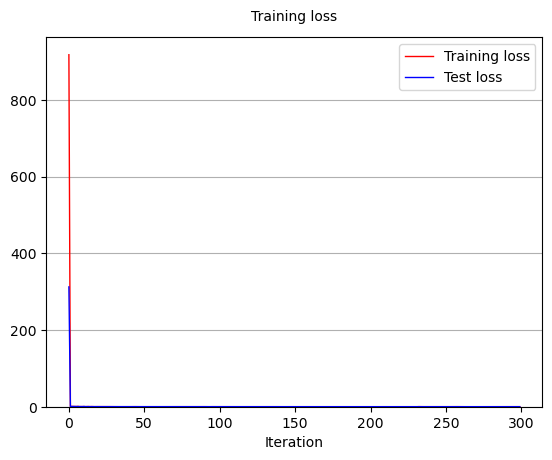

Evaluating error on test set:
Mean absolute percentage error: 0.1295141733222272
Mean absolute error: 0.21977643905414476
Mean root mean squared error: 0.3779394686771114


array([0.12951417, 0.21977644, 0.37793947])

In [10]:
file = "corona"
#file = "jpeg-large"
#file = "smallbank-1"
#file = "beethoven.wav"
#file = "ambivert"
#file = "ambivert.wav.tar"
#file = "Johnny_1280x720_60_short.y4m"
#file = "artificl.tar"
#file = "AUFNIRA_z3.637557.smt2"

data = pd.read_csv("C:/Users/nicho/Downloads/ISE coursework/Data sets/"+ file +".csv")
data_array = data.to_numpy()
print(f"Training network for {file} dataset")

x = data_array[:,:-1]
y = data_array[:,-1:]

features =  x.shape[1]
hidden = int(features * 7.5)
batch = int(x.shape[0] / 50)
rng = np.random.RandomState(seed=111111)
lr = 0
if file in ["Johnny_1280x720_60_short.y4m", "ambivert.wav.tar", "jpeg-large", "corona", "ambivert"]:
    lr = 3e-5
else:
    lr = 3e-3
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
network = Three_layer_network(rng=rng,
                            D_in=features,
                            D_hid_1=hidden)
training_network(network,
        MSE_loss,
        rng,
        x_train,
        y_train,
        x_test,
        y_test,
        batch_size=batch,
        learning_rate=lr,
        total_iters=300000,
        iters_per_recon_plot=1000)
print("Evaluating error on test set:")
evaluate(x_test, y_test)

Running for corona


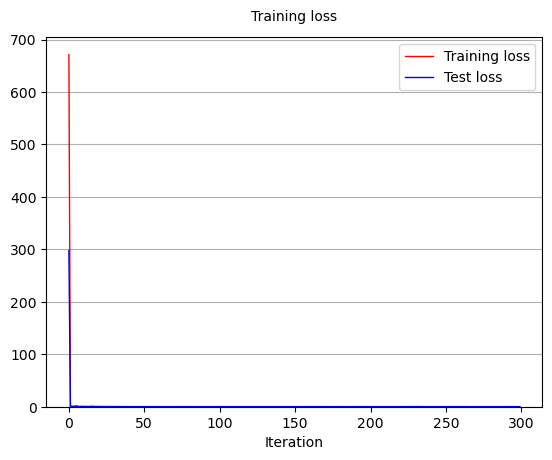

Evaluating error for corona network on test set:
Mean absolute percentage error: 0.1435001157935821
Mean absolute error: 0.22470012265774938
Mean root mean squared error: 0.33692361245214


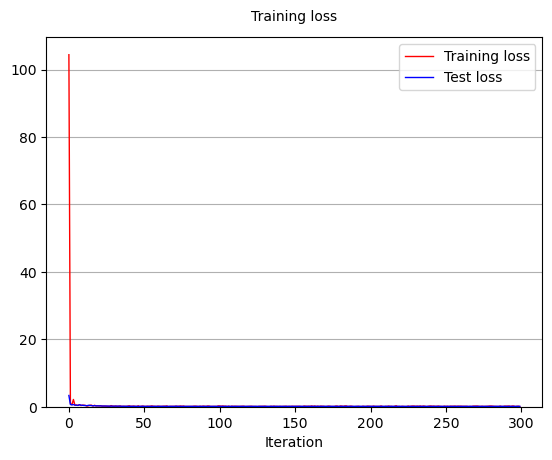

Evaluating error for corona network on test set:
Mean absolute percentage error: 0.12784494205956076
Mean absolute error: 0.19881760945750607
Mean root mean squared error: 0.3212252319548523


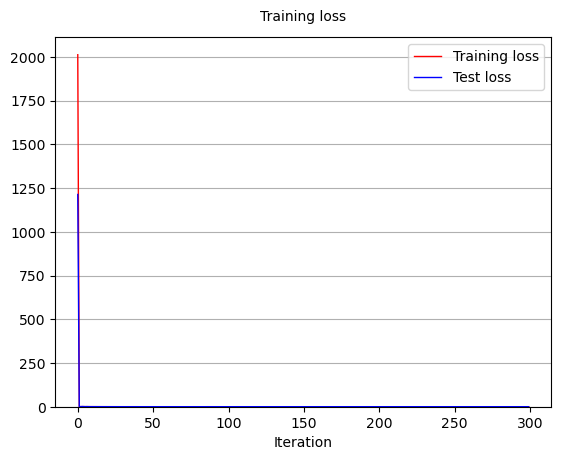

Evaluating error for corona network on test set:
Mean absolute percentage error: 0.11970223835682438
Mean absolute error: 0.19876685298151442
Mean root mean squared error: 0.3482487642237478
Running for jpeg-large


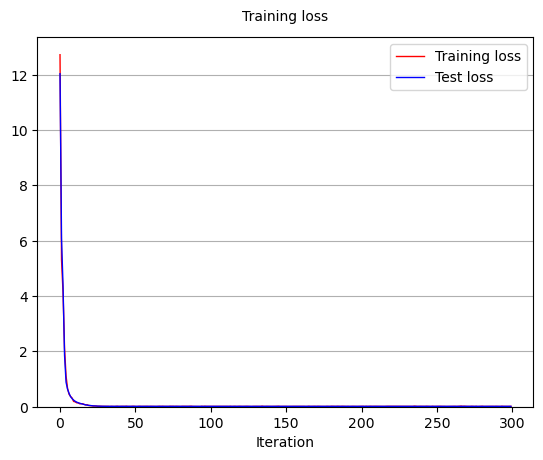

Evaluating error for jpeg-large network on test set:
Mean absolute percentage error: 0.025073413552923054
Mean absolute error: 0.08275860343660627
Mean root mean squared error: 0.11648204146102036


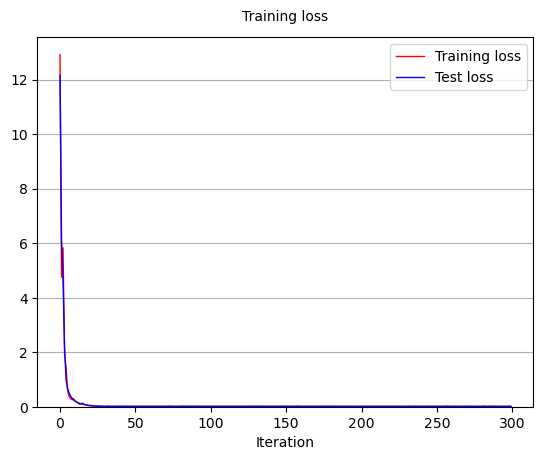

Evaluating error for jpeg-large network on test set:
Mean absolute percentage error: 0.024030134056364127
Mean absolute error: 0.08023498335730266
Mean root mean squared error: 0.11363662889294811


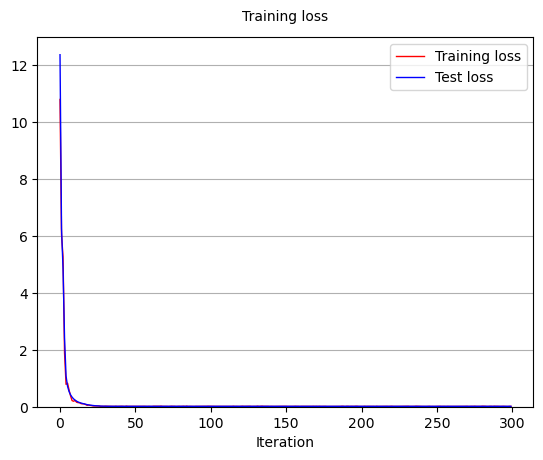

Evaluating error for jpeg-large network on test set:
Mean absolute percentage error: 0.024810066016036116
Mean absolute error: 0.08378265880011572
Mean root mean squared error: 0.12061552472858249
Running for smallbank-1


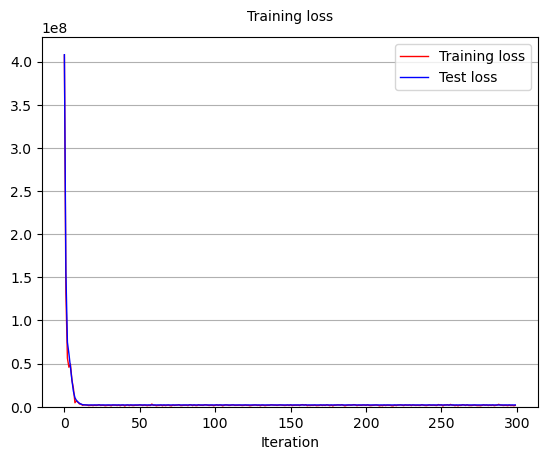

Evaluating error for smallbank-1 network on test set:
Mean absolute percentage error: 0.06125762504598299
Mean absolute error: 1203.8499469516491
Mean root mean squared error: 1424.5913465766967


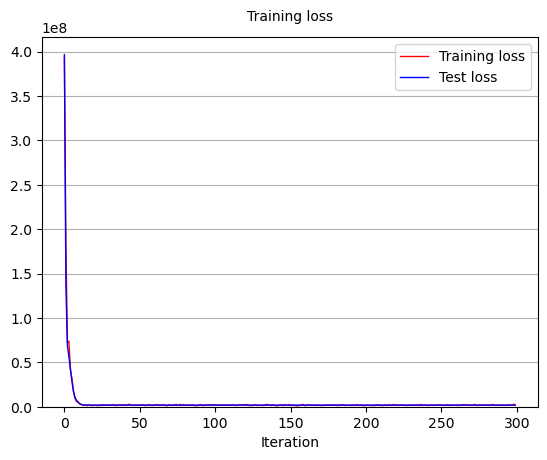

Evaluating error for smallbank-1 network on test set:
Mean absolute percentage error: 0.05825341870870317
Mean absolute error: 1131.016662259665
Mean root mean squared error: 1348.771774510833


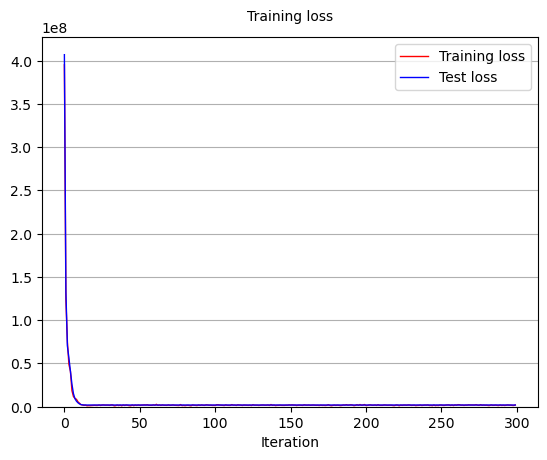

Evaluating error for smallbank-1 network on test set:
Mean absolute percentage error: 0.0592909918096359
Mean absolute error: 1166.5180579535752
Mean root mean squared error: 1400.249985309054
Running for beethoven.wav


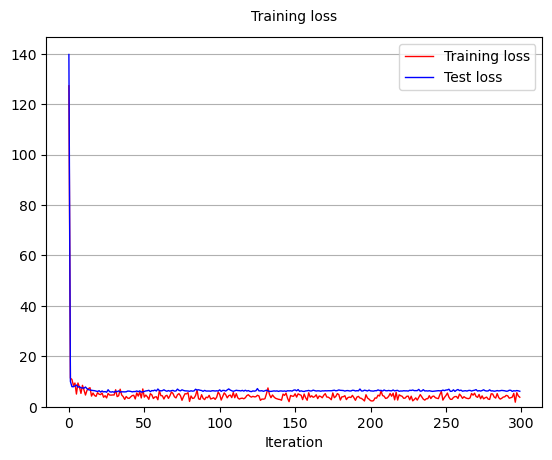

Evaluating error for beethoven.wav network on test set:
Mean absolute percentage error: 0.1808897776728541
Mean absolute error: 1.78307547636123
Mean root mean squared error: 2.4866568678631555


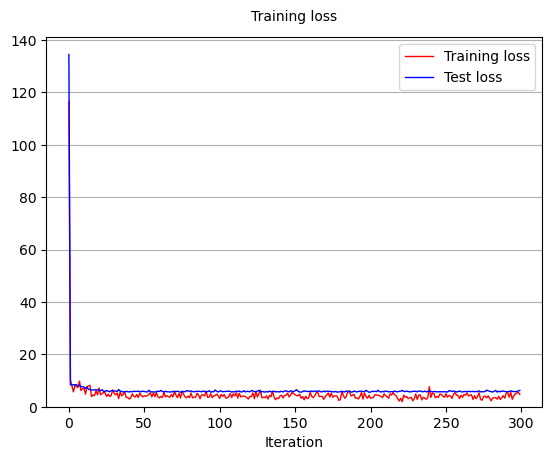

Evaluating error for beethoven.wav network on test set:
Mean absolute percentage error: 0.17680799810776476
Mean absolute error: 1.6843773445200598
Mean root mean squared error: 2.3922927479987703


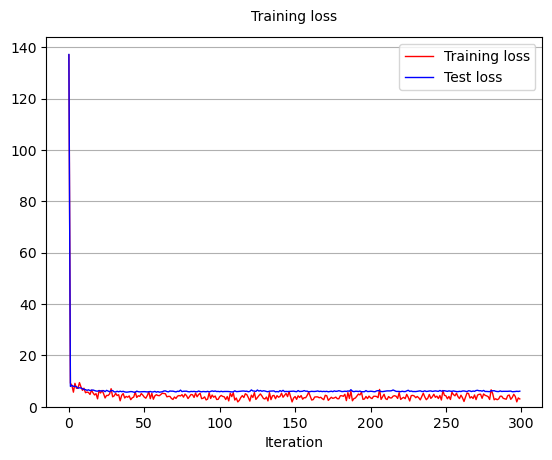

Evaluating error for beethoven.wav network on test set:
Mean absolute percentage error: 0.1857516915033346
Mean absolute error: 1.7624797790594002
Mean root mean squared error: 2.4697520728271734
Running for ambivert


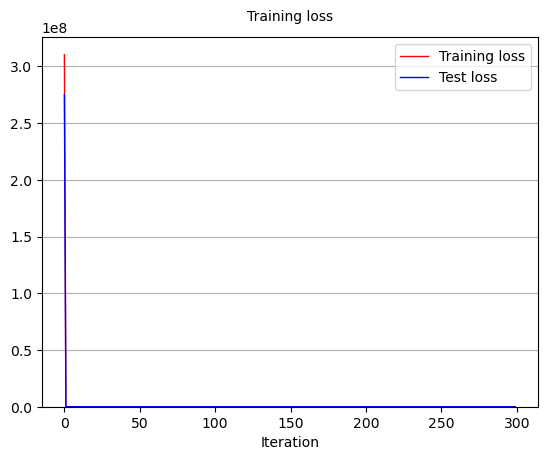

Evaluating error for ambivert network on test set:
Mean absolute percentage error: 0.6574373195342638
Mean absolute error: 12.006432479791934
Mean root mean squared error: 19.32456130407258


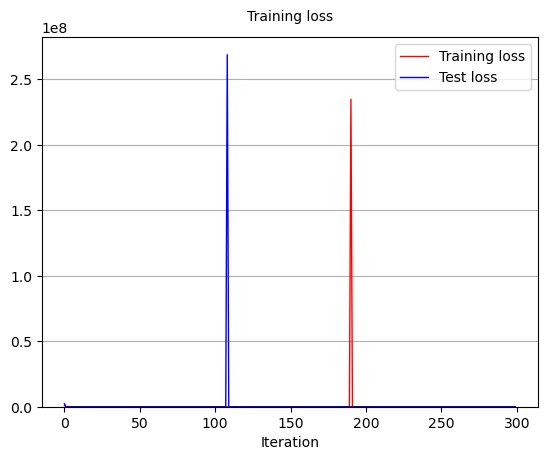

Evaluating error for ambivert network on test set:
Mean absolute percentage error: 0.6815829443811673
Mean absolute error: 11.882209293003793
Mean root mean squared error: 18.73842630547734


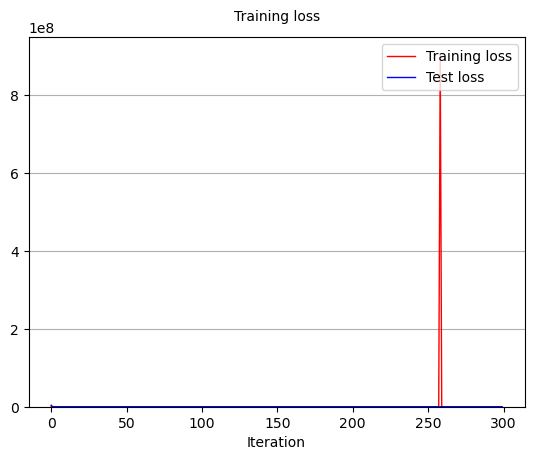

Evaluating error for ambivert network on test set:
Mean absolute percentage error: 0.6211380911291098
Mean absolute error: 11.930932951027609
Mean root mean squared error: 18.694161065922632
Running for ambivert.wav.tar


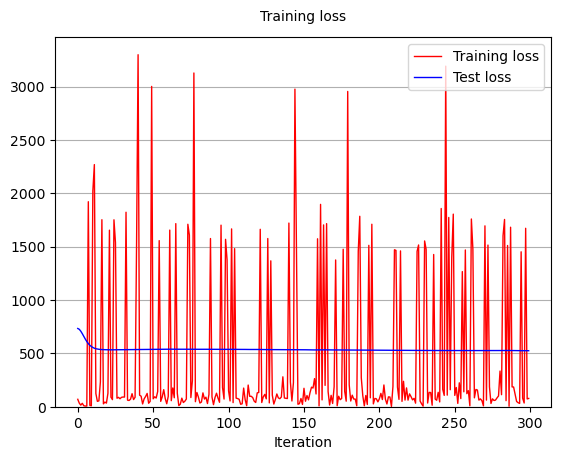

Evaluating error for ambivert.wav.tar network on test set:
Mean absolute percentage error: 1.2190481732460396
Mean absolute error: 13.950728541900371
Mean root mean squared error: 22.91101594490733


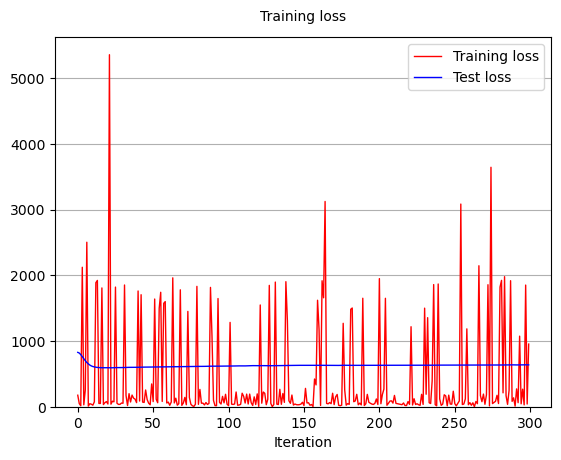

Evaluating error for ambivert.wav.tar network on test set:
Mean absolute percentage error: 1.6976610019362983
Mean absolute error: 16.030943175718704
Mean root mean squared error: 25.237348665114737


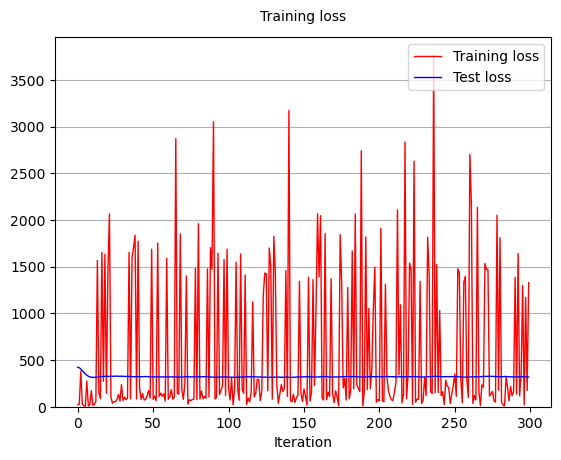

Evaluating error for ambivert.wav.tar network on test set:
Mean absolute percentage error: 1.7798067812529867
Mean absolute error: 12.227710727165485
Mean root mean squared error: 17.860327494470408
Running for Johnny_1280x720_60_short.y4m


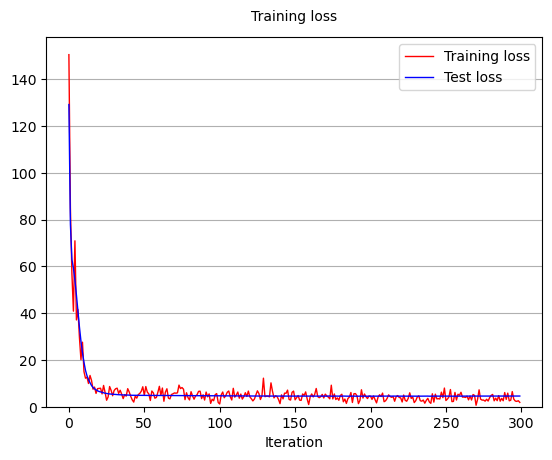

Evaluating error for Johnny_1280x720_60_short.y4m network on test set:
Mean absolute percentage error: 0.18713966702018345
Mean absolute error: 1.0960497528786834
Mean root mean squared error: 2.1327918905487633


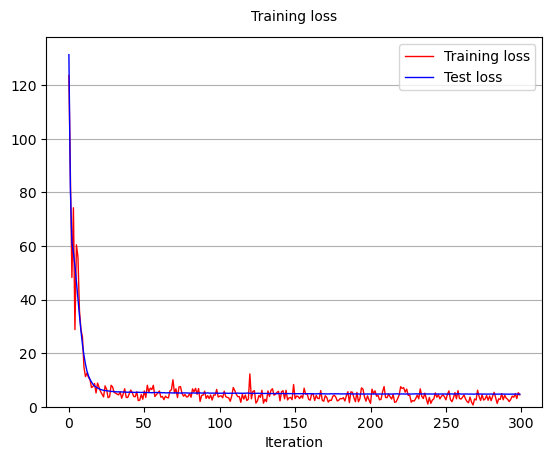

Evaluating error for Johnny_1280x720_60_short.y4m network on test set:
Mean absolute percentage error: 0.17769329962537647
Mean absolute error: 1.1241791131767012
Mean root mean squared error: 2.1798362554760753


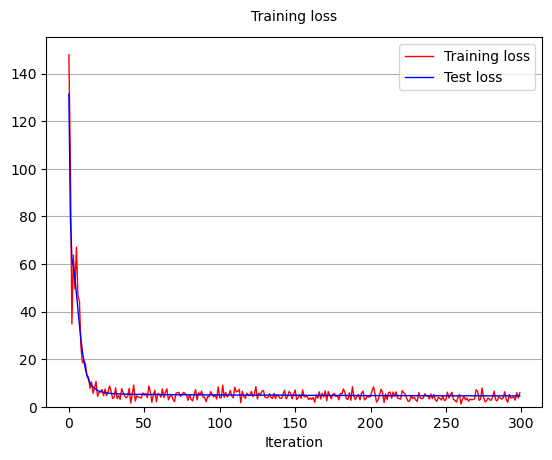

Evaluating error for Johnny_1280x720_60_short.y4m network on test set:
Mean absolute percentage error: 0.1815290477699285
Mean absolute error: 1.1173658841631398
Mean root mean squared error: 2.128024827369079
Running for artificl.tar


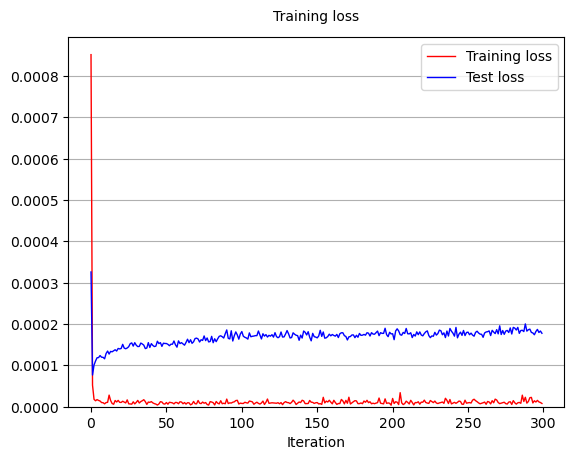

Evaluating error for artificl.tar network on test set:
Mean absolute percentage error: 0.4348466746308583
Mean absolute error: 0.010232014634475732
Mean root mean squared error: 0.013737953766303037


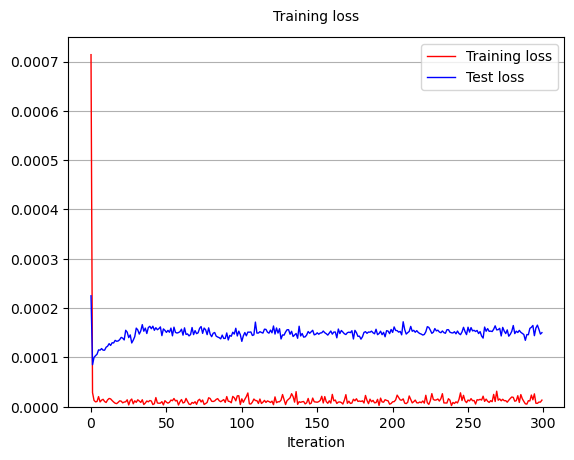

Evaluating error for artificl.tar network on test set:
Mean absolute percentage error: 0.42604190192444047
Mean absolute error: 0.00907898704741771
Mean root mean squared error: 0.012197713978548021


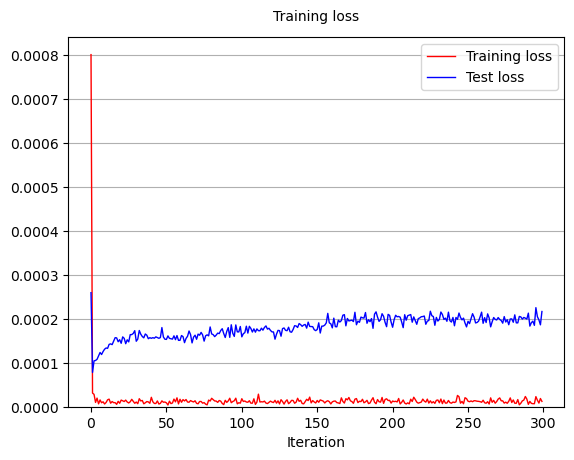

Evaluating error for artificl.tar network on test set:
Mean absolute percentage error: 0.47051920671429903
Mean absolute error: 0.010711839983814085
Mean root mean squared error: 0.01416561323581652
Running for AUFNIRA_z3.637557.smt2


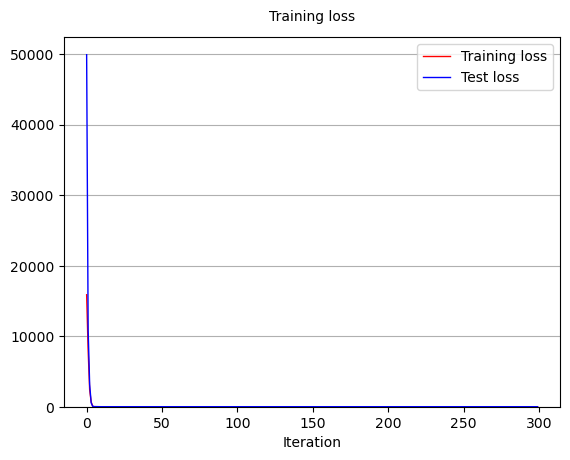

Evaluating error for AUFNIRA_z3.637557.smt2 network on test set:
Mean absolute percentage error: 0.0760592007738981
Mean absolute error: 1.2077330661056072
Mean root mean squared error: 1.5822506760911597


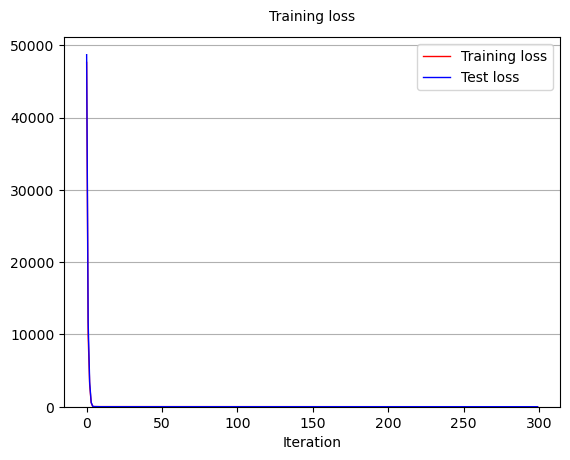

Evaluating error for AUFNIRA_z3.637557.smt2 network on test set:
Mean absolute percentage error: 0.08597369136298909
Mean absolute error: 1.1120637081637237
Mean root mean squared error: 1.4390845571885897


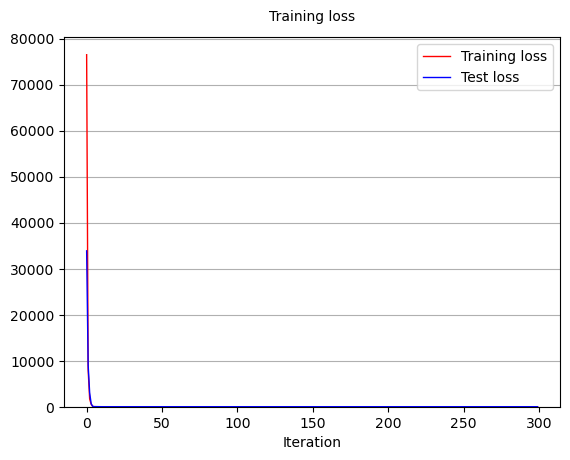

Evaluating error for AUFNIRA_z3.637557.smt2 network on test set:
Mean absolute percentage error: 0.09414222610796959
Mean absolute error: 0.9833186703546606
Mean root mean squared error: 1.2859444176078836


In [ ]:
path = str(Path.cwd())
files = ["corona","jpeg-large","smallbank-1","beethoven.wav","ambivert","ambivert.wav.tar","Johnny_1280x720_60_short.y4m","artificl.tar","AUFNIRA_z3.637557.smt2"]
for file in files:

    data = pd.read_csv(path + "/data sets/"+ file +".csv")
    print(f"Running for {file}")
    data_array = data.to_numpy()

    x = data_array[:,:-1]
    y = data_array[:,-1:]

    features =  x.shape[1]
    hidden = int(features * 7.5)
    batch = int(x.shape[0] / 50)
    rng = np.random.RandomState(seed=111111)
    lr = 0
    if file in ["Johnny_1280x720_60_short.y4m", "ambivert.wav.tar", "jpeg-large", "corona", "ambivert"]:
        lr = 3e-5
    else:
        lr = 3e-3
    repetitions = 1
    metrics = np.zeros((repetitions,3))
    for i in range(repetitions):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
        network = Three_layer_network(rng=rng,
                               D_in=features,
                               D_hid_1=hidden)
        training_network(network,
                MSE_loss,
                rng,
                x_train,
                y_train,
                x_test,
                y_test,
                batch_size=batch,
                learning_rate=lr,
                total_iters=300000,
                iters_per_recon_plot=1000)
        print(f"Evaluating error for {file} network on test set:")
        metrics[i] = evaluate(x_test, y_test)
    with open(path + "/data analysis/" + file +" test_set analysis.csv", 'w', newline='') as file_object:
        writer_object = writer(file_object)
        for j  in range(metrics.shape[0]):
            writer_object.writerow(metrics[j])